# A1. Dataset and Setup

### Loading the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from enum import Enum

data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

print(f"Total samples: {X.shape[0]}")
print(f"Total features: {X.shape[1]}")


Total samples: 569
Total features: 30


### Standardization

In [2]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)


# A2. PCA Implementation

In [3]:
class PCA:
    def __init__(self, desired_dim):
        self.desired_dim =desired_dim 
        self.principal_components = None
        self.mean_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        # 1. Zero center the data
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Rowvar=False because rows are samples, cols are features
        cov_matrix = np.cov(X_centered, rowvar=False)

        # eigh is used for symmetric matrices
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]

        self.principal_components = sorted_eigenvectors[:, :self.desired_dim]

        # 6. Explained variance ratio
        total_variance = np.sum(sorted_eigenvalues)
        self.explained_variance_ratio_ = sorted_eigenvalues[:self.desired_dim] / total_variance

    def transform(self, X):
        X_centered = X - self.mean_
        return np.dot(X_centered, self.principal_components)

    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.principal_components.T) + self.mean_

    def compute_reconstruction_error(self, X, X_reconstructed):
        #MSE
        return np.mean(np.square(X - X_reconstructed))


# A3. K-Means Implementation

In [4]:
class initMethod(Enum):
    RANDOM = 'random'
    KMEANS_PP = 'kmeans++'
class KMeans:
    def __init__(self, num_clusters, max_iter = 300, tol = 1e-6, init_method = initMethod.RANDOM, random_state = None):

        self.init_method = init_method
        self.centroids_ = None
        self.num_clusters =num_clusters 
        self.max_iter = max_iter
        self.tol = tol
        self.inertia_history_ = []
        self.random_state = random_state
        if random_state:
            np.random.seed(random_state)

    def _initialize_centroids(self, X):
        n_samples, n_features = X.shape

        if self.init_method == initMethod.RANDOM:

            #replace=False to avoid duplicate centroids
            indices = np.random.choice(n_samples, self.num_clusters, replace=False)
            self.centroids_ = X[indices]

        elif self.init_method == initMethod.KMEANS_PP: 
            #first one is random
            centroids = [X[np.random.randint(n_samples)]]

            for  i in range(1, self.num_clusters):
                #for everypoint x get the squared distances from every centroid and take the minimum
                distances = np.array([min([np.sum((x - c) ** 2) for c in centroids]) for x in X])
                weighted_prob = distances / np.sum(distances)
                next_centroid_idx = np.random.choice(n_samples, p=weighted_prob)
                centroids.append(X[next_centroid_idx])

            self.centroids_ = np.array(centroids)

    def euclidean_distance(self, X, centroids):
        # X: n*d , centroids: K*d
        num_points = X.shape[0]
        num_centroids = centroids.shape[0]
        distances = np.zeros((num_points, num_centroids))
        for i in range(num_points):
            for j in range(num_centroids):
                diff = X[i] - centroids[j]
                distances[i, j] = np.sqrt(np.sum(diff**2))

        return distances #Points*centroids
    def fit(self, X):
        self.inertia_history_ = []
        self._initialize_centroids(X)

        for i in range(self.max_iter):
            distances = self.euclidean_distance(X, self.centroids_)
            labels = np.argmin(distances, axis=1) # n elements and each has the cluster(centroid) number(index)

            # compute inertia
            inertia = np.sum((X - self.centroids_[labels]) ** 2)
            self.inertia_history_.append(inertia)

            new_centroids = np.zeros((self.num_clusters, X.shape[1])) # empty NP array
            for i in range(self.num_clusters):
                points_in_cluster = X[labels == i]
                if len(points_in_cluster) > 0:
                    new_centroids[i] = np.mean(points_in_cluster, axis=0)
                else:
                    # If a cluster is empty, keep the old position -- if the cluster have no points assigned to it
                    new_centroids[i] = self.centroids_[i]

            # Check convergence
            change_in_centroids = np.sum((self.centroids_ - new_centroids) ** 2)
            if change_in_centroids < self.tol:
                self.centroids_ = new_centroids
                break

            self.centroids_ = new_centroids

        self.labels_ = labels
        self.inertia_ = self.inertia_history_[-1]


# A4. Execution and Results

PCA shape: (569, 2)
Explained Variance Ratio: [0.44272026 0.18971182]


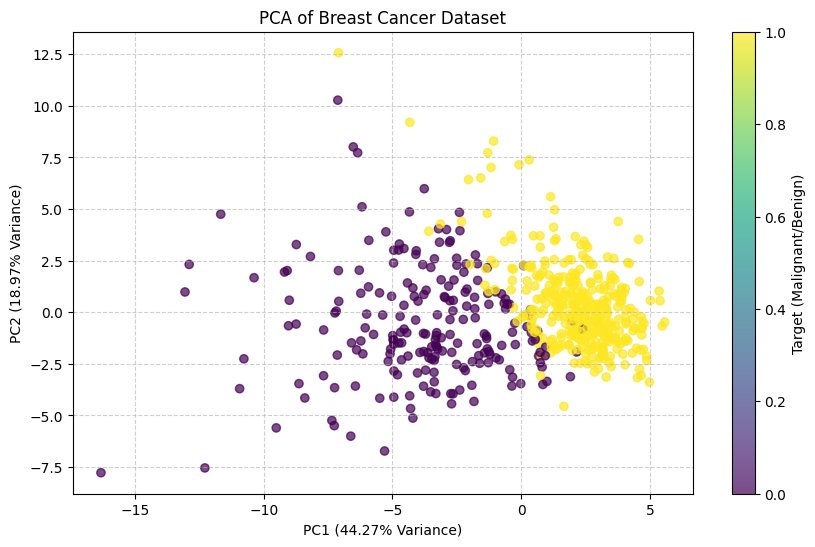

In [5]:
# PCA Execution
pca = PCA(desired_dim=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)

print(f"PCA shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Plot PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('PCA of Breast Cancer Dataset')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.colorbar(scatter, label='Target (Malignant/Benign)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


KMeans (KMeans++) Inertia: 11595.5266


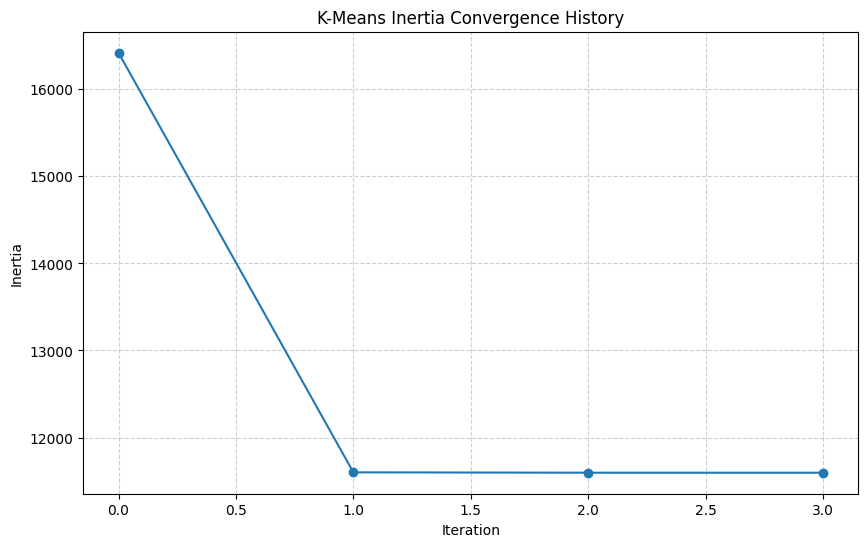

In [6]:
# K-Means Execution (KMeans++)
kmeans = KMeans(num_clusters=2, init_method=initMethod.KMEANS_PP ,random_state=42)
kmeans.fit(X_std)
print(f"KMeans (KMeans++) Inertia: {kmeans.inertia_:.4f}")

# Plot Inertia History
plt.figure(figsize=(10, 6))
plt.plot(kmeans.inertia_history_, marker='o')
plt.title('K-Means Inertia Convergence History')
plt.xlabel('Iteration')
plt.ylabel('Inertia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [7]:

kmeans_random = KMeans(num_clusters=2, init_method=initMethod.RANDOM, random_state=42)
kmeans_random.fit(X_std)
print(f"KMeans (Random) Inertia: {kmeans_random.inertia_:.4f}")
print(f"Random Iterations: {len(kmeans_random.inertia_history_)}")
print(f"KMeans++ Iterations: {len(kmeans.inertia_history_)}")


KMeans (Random) Inertia: 11595.6833
Random Iterations: 9
KMeans++ Iterations: 4


# A5. Experiment 1: K-Means on Original Data

## 1. Optimal k Finding (Elbow, Silhouette, Gap Statistic)

In [8]:

from InternalValidation import *
def calculate_gap_statistic(X, k_max=10, n_refs=5):
    gaps = []
    
    for k in range(1, k_max + 1):
        # 1. Fit on Actual Data
        km_act = KMeans(num_clusters=k, init_method=initMethod.KMEANS_PP, random_state=1)
        km_act.fit(X)
        inertia_act = km_act.inertia_
        
        # 2. Fit on Reference Data (Random Uniform)
        ref_inertias = []
        for i in range(n_refs):
            # Create random data within the same bounding box as X
            X_ref = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), X.shape)
            km_ref = KMeans(num_clusters=k, init_method=initMethod.KMEANS_PP, random_state=42)
            km_ref.fit(X_ref)
            ref_inertias.append(km_ref.inertia_)
            
        # 3. Calculate Gap
        # Expected Log Inertia - Actual Log Inertia
        gap = np.mean(np.log(ref_inertias)) - np.log(inertia_act)
        gaps.append(gap)
        
    return gaps

Calculating Optimal k...
k=1: Inertia=17070.00, Silhouette=0.0000
k=2: Inertia=11595.53, Silhouette=0.3434
k=3: Inertia=10061.80, Silhouette=0.3144
k=4: Inertia=9339.39, Silhouette=0.1571
k=5: Inertia=8885.01, Silhouette=0.1434
k=6: Inertia=8394.43, Silhouette=0.1479
k=7: Inertia=7849.31, Silhouette=0.1316
k=8: Inertia=7276.95, Silhouette=0.1434
k=9: Inertia=7364.37, Silhouette=0.1359
k=10: Inertia=6873.59, Silhouette=0.1567
Calculating Gap Statistic...

Optimal k - Elbow Method: 2
Optimal k - Silhouette: 2
Optimal k - Gap Statistic: 11


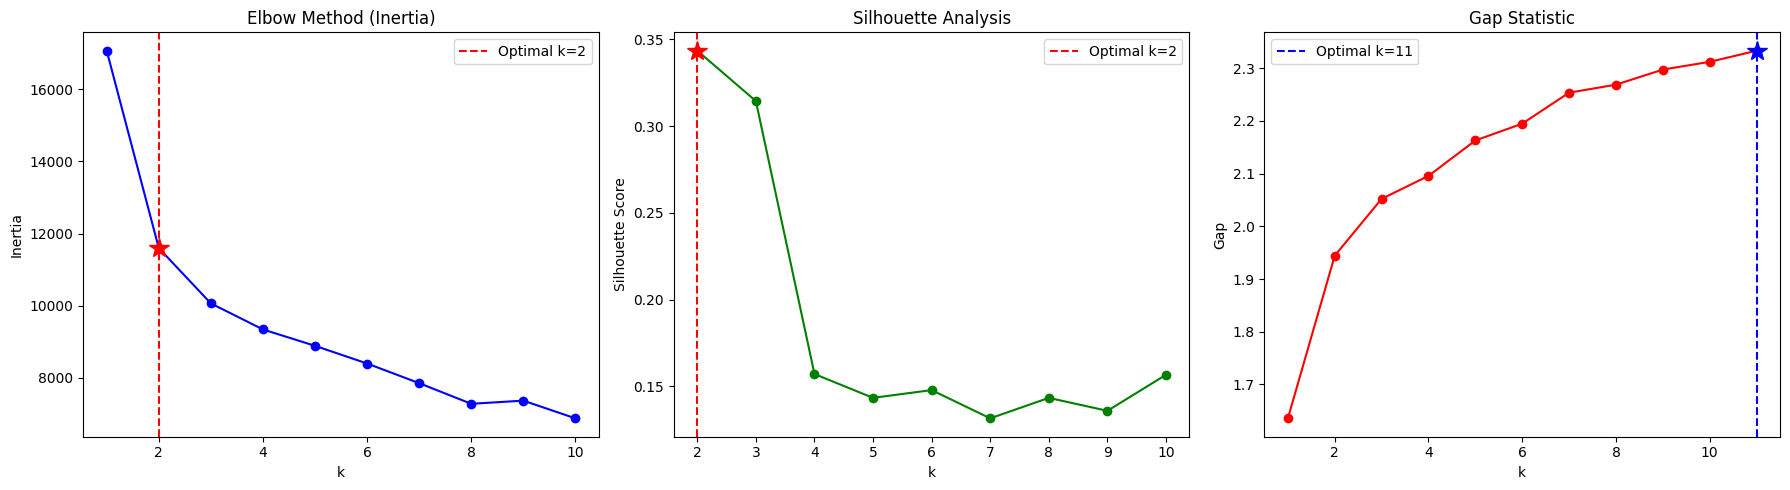

In [9]:
k_range1 = range(1, 11)
inertias = []
silhouettes = []

print("Calculating Optimal k...")
for k in k_range1:
    kmeans = KMeans(num_clusters=k, init_method=initMethod.KMEANS_PP, random_state=42)
    kmeans.fit(X_std)
    inertias.append(kmeans.inertia_)

    score = calculate_silhouette_score(X_std, kmeans.labels_)
    silhouettes.append(score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.4f}")

k_max=11 
print("Calculating Gap Statistic...")
gaps = calculate_gap_statistic(X_std, k_max, n_refs=5)
#find optimal key for all methods
diffs = np.diff(inertias)
diffs2 = np.diff(diffs)
optimal_k_elbow = np.argmax(diffs2) + 2  # +2 because of double diff

# Silhouette: maximum score (skip k=1)
optimal_k_silhouette = np.argmax(silhouettes[1:]) + 2  # +2 because we start from k=2

# Gap: maximum gap
optimal_k_gap = np.argmax(gaps) + 1  # +1 because range starts at 1

print(f"\nOptimal k - Elbow Method: {optimal_k_elbow}")
print(f"Optimal k - Silhouette: {optimal_k_silhouette}")
print(f"Optimal k - Gap Statistic: {optimal_k_gap}")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow
axes[0].plot(k_range1, inertias, 'bo-')
axes[0].axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k={optimal_k_elbow}')
axes[0].plot(optimal_k_elbow, inertias[optimal_k_elbow-1], 'r*', markersize=15)
axes[0].set_title('Elbow Method (Inertia)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].legend()

# Silhouette
k_range = range(2, 11)
axes[1].plot(k_range, silhouettes[1:], 'go-')
axes[1].axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k={optimal_k_silhouette}')
axes[1].plot(optimal_k_silhouette, silhouettes[optimal_k_silhouette-1], 'r*', markersize=15)
axes[1].set_title('Silhouette Analysis')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend()

# Gap Statistic
axes[2].plot(range(1, k_max + 1), gaps, 'ro-')
axes[2].axvline(x=optimal_k_gap, color='b', linestyle='--', label=f'Optimal k={optimal_k_gap}')
axes[2].plot(optimal_k_gap, gaps[optimal_k_gap-1], 'b*', markersize=15)
axes[2].set_title('Gap Statistic')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Gap')
axes[2].legend()

plt.tight_layout()
plt.show()

Calculating Optimal k...
k=1: Davies-Bouldin=0.0000, Calinski-Harabasz=0.00
k=2: Davies-Bouldin=1.3205, Calinski-Harabasz=267.69
k=3: Davies-Bouldin=1.5294, Calinski-Harabasz=197.11
k=4: Davies-Bouldin=1.8763, Calinski-Harabasz=155.89
k=5: Davies-Bouldin=1.8565, Calinski-Harabasz=129.89
k=6: Davies-Bouldin=1.6394, Calinski-Harabasz=116.37
k=7: Davies-Bouldin=1.5455, Calinski-Harabasz=110.03
k=8: Davies-Bouldin=1.4686, Calinski-Harabasz=107.85
k=9: Davies-Bouldin=1.3114, Calinski-Harabasz=92.25
k=10: Davies-Bouldin=1.4446, Calinski-Harabasz=92.14
Optimal k - Davies-Bouldin: 9
Optimal k - Calinski-Harabasz: 2


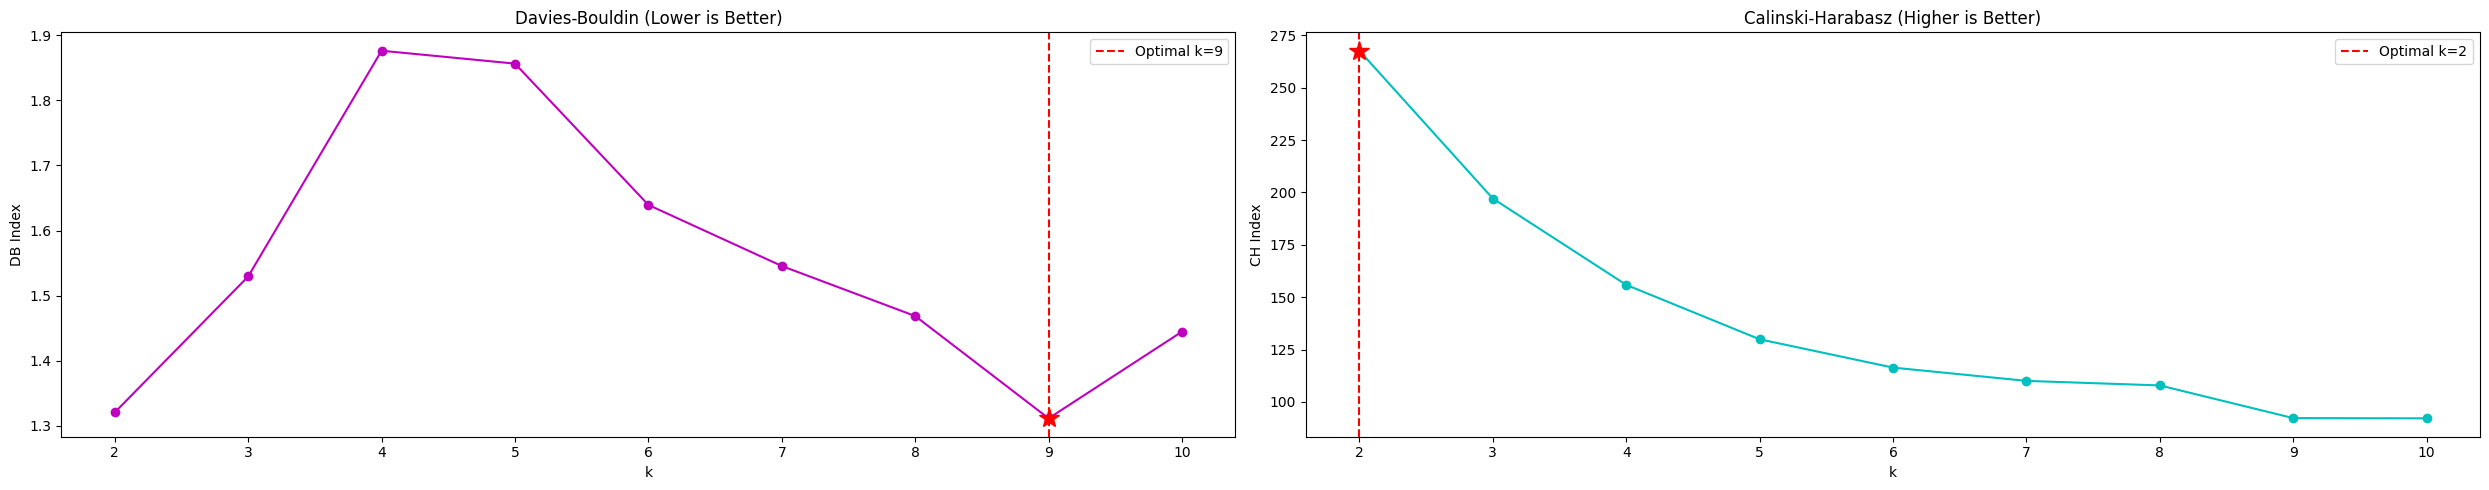

In [10]:
k_range1 = range(1, 11)
davies_bouldin = []
calinski_harabasz = []

print("Calculating Optimal k...")
for k in k_range1:
    kmeans = KMeans(num_clusters=k, init_method=initMethod.KMEANS_PP, random_state=42)
    kmeans.fit(X_std)
    
    db_score = calculate_davies_bouldin_index(X_std, kmeans.labels_)
    davies_bouldin.append(db_score)
    
    ch_score = calculate_calinski_harabasz_index(X_std, kmeans.labels_)
    calinski_harabasz.append(ch_score)
    
    print(f"k={k}: Davies-Bouldin={db_score:.4f}, Calinski-Harabasz={ch_score:.2f}")

# Find optimal k
optimal_k_db = np.argmin(davies_bouldin[1:]) + 2  # Lower is better
optimal_k_ch = np.argmax(calinski_harabasz[1:]) + 2  # Higher is better

print(f"Optimal k - Davies-Bouldin: {optimal_k_db}")
print(f"Optimal k - Calinski-Harabasz: {optimal_k_ch}")

fig, axes = plt.subplots(1, 2, figsize=(25, 5))



# Davies-Bouldin
axes[0].plot(k_range, davies_bouldin[1:], 'mo-')
axes[0].axvline(x=optimal_k_db, color='r', linestyle='--', label=f'Optimal k={optimal_k_db}')
axes[0].plot(optimal_k_db, davies_bouldin[optimal_k_db-1], 'r*', markersize=15)
axes[0].set_title('Davies-Bouldin (Lower is Better)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('DB Index')
axes[0].legend()

# Calinski-Harabasz
axes[1].plot(k_range, calinski_harabasz[1:], 'co-')
axes[1].axvline(x=optimal_k_ch, color='r', linestyle='--', label=f'Optimal k={optimal_k_ch}')
axes[1].plot(optimal_k_ch, calinski_harabasz[optimal_k_ch-1], 'r*', markersize=15)
axes[1].set_title('Calinski-Harabasz (Higher is Better)')
axes[1].set_xlabel('k')
axes[1].set_ylabel('CH Index')
axes[1].legend()

plt.tight_layout()
plt.show()

## 2. Comparison: K-Means++ vs Random Initialization Results & Convergence Speed

In [11]:
k_optimal = 2 
iter = 10

random_converge = []
pp_converge = []
random_inertia = []
pp_inertia = []

print(f"Comparing Initialization Methods (k={k_optimal}, {iter} iterations)...")

for i in range(iter):
    # Random
    km_rand = KMeans(num_clusters=k_optimal, init_method=initMethod.RANDOM, random_state=42)
    km_rand.fit(X_std)
    random_converge.append(len(km_rand.inertia_history_))
    random_inertia.append(km_rand.inertia_)
    
    # K-Means++
    km_pp = KMeans(num_clusters=k_optimal, init_method=initMethod.KMEANS_PP, random_state=42)
    km_pp.fit(X_std)
    pp_converge.append(len(km_pp.inertia_history_))
    pp_inertia.append(km_pp.inertia_)

# Report
print("\n--- Convergence Speed (Iterations) ---")
print(f"Random: Mean={np.mean(random_converge):.2f}") 
print(f"K-Means++: Mean={np.mean(pp_converge):.2f}")

print("\n--- Final Inertia ---")
print(f"Random: Mean={np.mean(random_inertia):.2f}")
print(f"K-Means++: Mean={np.mean(pp_inertia):.2f}")

Comparing Initialization Methods (k=2, 10 iterations)...

--- Convergence Speed (Iterations) ---
Random: Mean=9.00
K-Means++: Mean=4.00

--- Final Inertia ---
Random: Mean=11595.68
K-Means++: Mean=11595.53


# A7. Experiment 3: K-Means after PCA


PCs=2: Recon Error=0.3676, Inertia=5332.56, Silhouette=0.5085, DB=0.8467, CH=580.8763
PCs=5: Recon Error=0.1527, Inertia=8992.13, Silhouette=0.3919, DB=1.1489, CH=345.0383
PCs=10: Recon Error=0.0484, Inertia=10770.55, Silhouette=0.3565, DB=1.2679, CH=288.1042
PCs=15: Recon Error=0.0135, Inertia=11365.57, Silhouette=0.3461, DB=1.3065, CH=273.0733
PCs=20: Recon Error=0.0044, Inertia=11520.17, Silhouette=0.3438, DB=1.3159, CH=269.4318
PCA shape: (569, 2)
Explained Variance Ratio: [0.44272026 0.18971182]


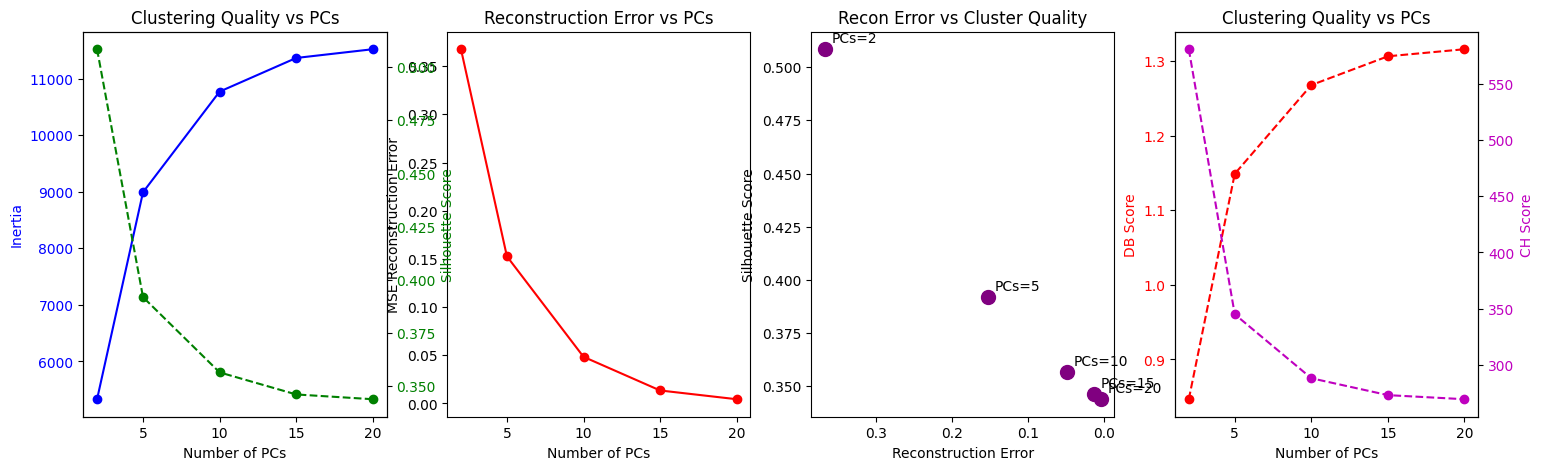

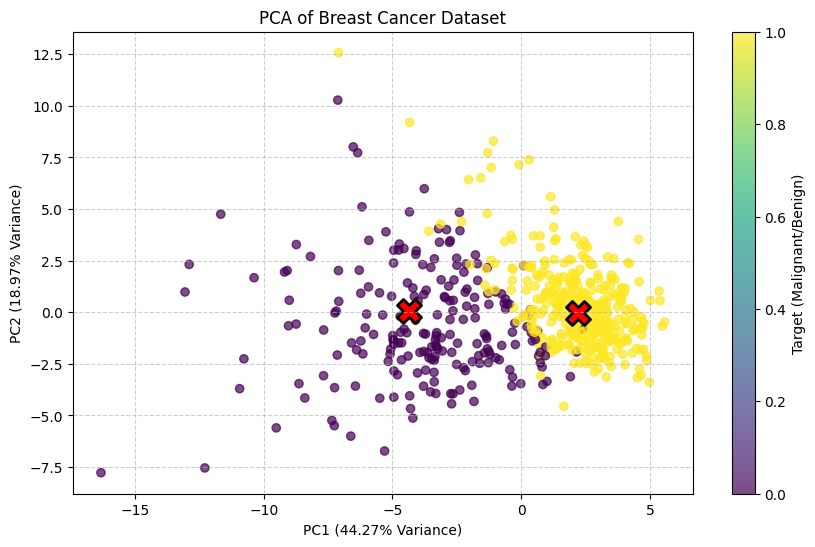

<Figure size 640x480 with 0 Axes>

In [12]:
pc_counts = [2, 5, 10, 15, 20]
reconstruction_errors = []
inertias_pca = []
silhouettes_pca = []
db_scores_pca = []
ch_scores_pca = []

for i in pc_counts:
    # 1. PCA
    pca_exp = PCA(desired_dim=i)
    pca_exp.fit(X_std)
    X_pca_exp = pca_exp.transform(X_std)
    
    # 2. Reconstruction Error
    X_reconstructed = pca_exp.inverse_transform(X_pca_exp)
    error = pca_exp.compute_reconstruction_error(X_std, X_reconstructed)
    reconstruction_errors.append(error)
    
    # 3. K-Means on Reduced Data
    # We use k=2 for consistency to compare quality across dimensions
    kmeans_pca = KMeans(num_clusters=2, init_method=initMethod.KMEANS_PP, random_state=42)
    kmeans_pca.fit(X_pca_exp)
    inertias_pca.append(kmeans_pca.inertia_)
    
    # Silhouette on reduced data
    sil_score = calculate_silhouette_score(X_pca_exp, kmeans_pca.labels_)
    db_score = calculate_davies_bouldin_index(X_pca_exp, kmeans_pca.labels_)
    ch_score = calculate_calinski_harabasz_index(X_pca_exp, kmeans_pca.labels_)

    silhouettes_pca.append(sil_score)
    db_scores_pca.append(db_score)
    ch_scores_pca.append(ch_score)

    
    print(f"PCs={i}: Recon Error={error:.4f}, Inertia={kmeans_pca.inertia_:.2f}, Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.4f}")

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# 1. Dimensionality vs Clustering Quality (Inertia & Silhouette)
ax1 = axes[0]
ax1.set_title('Clustering Quality vs PCs')
ax1.set_xlabel('Number of PCs')
ax1.set_ylabel('Inertia', color='b')
ax1.plot(pc_counts, inertias_pca, 'bo-', label='Inertia')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='g')
ax2.plot(pc_counts, silhouettes_pca, 'go--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='g')


# 2. Dimensionality vs Reconstruction Error
axes[1].plot(pc_counts, reconstruction_errors, 'ro-')
axes[1].set_title('Reconstruction Error vs PCs')
axes[1].set_xlabel('Number of PCs')
axes[1].set_ylabel('MSE Reconstruction Error')

# 3. Reconstruction Error vs Clustering Performance (Silhouette)
axes[2].scatter(reconstruction_errors, silhouettes_pca, c='purple', s=100)
for i, txt in enumerate(pc_counts):
    axes[2].annotate(f"PCs={txt}", (reconstruction_errors[i], silhouettes_pca[i]), xytext=(5, 5), textcoords='offset points')
axes[2].set_title('Recon Error vs Cluster Quality')
axes[2].set_xlabel('Reconstruction Error')
axes[2].set_ylabel('Silhouette Score')
axes[2].invert_xaxis() # Lower error is better (right to left)

ax3 =axes[3] 
ax3.set_title('Clustering Quality vs PCs')
ax3.set_xlabel('Number of PCs')
ax3.set_ylabel('DB Score', color='r')
ax3.plot(pc_counts, db_scores_pca, 'ro--', label='DB')
ax3.tick_params(axis='y', labelcolor='r')

ax4 = ax3.twinx()
ax4.set_ylabel('CH Score', color='m')
ax4.plot(pc_counts, ch_scores_pca, 'mo--', label='CH')
ax4.tick_params(axis='y', labelcolor='m')

# PCA with KMeans Clustering Overlay

pca = PCA(desired_dim=2)
pca.fit(X_std)
X_pca = pca.transform(X_std)
kmeans = KMeans(num_clusters=2, init_method=initMethod.KMEANS_PP ,random_state=42)
kmeans.fit(X_pca)
print(f"PCA shape: {X_pca.shape}")
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")
# Plot PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
centroids = kmeans.centroids_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            c='red', marker='X', s=300, 
            edgecolors='black', linewidths=2,
            label='Centroids')
plt.title('PCA of Breast Cancer Dataset')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Variance)')
plt.colorbar(scatter, label='Target (Malignant/Benign)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

plt.tight_layout()
plt.show()